In [19]:
import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)

tf.test.is_built_with_cuda()
print(tf.config.experimental.list_physical_devices('GPU'))
print(tf.config.experimental.list_logical_devices('GPU'))


2.3.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np

## Fig 7 (top)
img_path  = 'inpainting/kate.png'
mask_path = 'inpainting/kate_mask.png'

## UTILS

In [42]:
from PIL import Image

def load(path):
    """Load PIL image."""
    img = Image.open(path)
    return img

def pil_to_np(img_PIL):
    '''Converts image in PIL format to np.array.
    
    From W x H x C [0...255] to C x W x H [0..1]
    '''
    ar = np.array(img_PIL)

    if len(ar.shape) == 3:
        ar = ar.transpose(2,0,1)
    else:
        ar = ar[None, ...]

    return ar.astype(np.float32) / 255.

def get_image(path, imsize=-1):
    """Load an image and resize to a cpecific size. 

    Args: 
        path: path to image
        imsize: tuple or scalar with dimensions; -1 for `no resize`
    """
    img = load(path)

    if isinstance(imsize, int):
        imsize = (imsize, imsize)

    if imsize[0]!= -1 and img.size != imsize:
        if imsize[0] > img.size[0]:
            img = img.resize(imsize, Image.BICUBIC)
        else:
            img = img.resize(imsize, Image.ANTIALIAS)

    img_np = pil_to_np(img)

    return img, img_np


def crop_image(img, d=32):
    '''Make dimensions divisible by `d`'''

    new_size = (img.size[0] - img.size[0] % d, 
                img.size[1] - img.size[1] % d)

    bbox = [
            int((img.size[0] - new_size[0])/2), 
            int((img.size[1] - new_size[1])/2),
            int((img.size[0] + new_size[0])/2),
            int((img.size[1] + new_size[1])/2),
    ]

    img_cropped = img.crop(bbox)
    return img_cropped


from mpl_toolkits.axes_grid1 import ImageGrid
import math
def plot_image_grid(images_np, nrow =8, factor=1, interpolation='lanczos'):
    """Draws images in a grid
    
    Args:
        images_np: list of images, each image is np.array of size 3xHxW of 1xHxW
        nrow: how many images will be in one row
        factor: size if the plt.figure 
        interpolation: interpolation used in plt.imshow
    """
    n_channels = max(x.shape[0] for x in images_np)
    assert (n_channels == 3) or (n_channels == 1), "images should have 1 or 3 channels"
    
    images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]

    plt.figure(figsize=(len(images_np) + factor, 12 + factor))
    lines = math.floor(len(images_np) / nrow)
    for ind, im in enumerate(images_np):
        plt.subplot(int(f'{lines}{nrow}{ind+1}'))
        plt.axis('off')
        if images_np[0].shape[0] == 1:
            plt.imshow(im[0], cmap='gray', interpolation=interpolation)
        else:
            plt.imshow(im.transpose(1, 2, 0), interpolation=interpolation)
    plt.show()


## PREPROCESSING

In [22]:
imsize = -1

img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

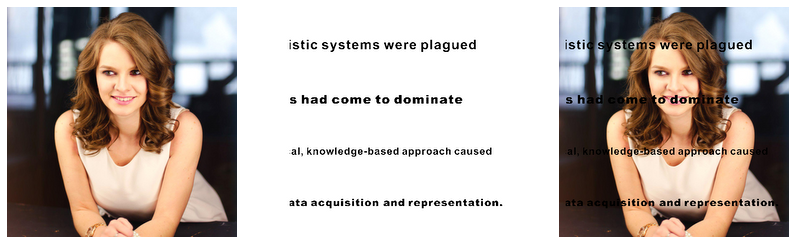

In [43]:
# center crop
dim_div_by = 64
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)


# visualize

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11)

## MODELS

In [44]:
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, Activation, UpSampling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.models import Sequential
def skip(
        num_input_channels=2, num_output_channels=3, 
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4], 
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True,
        pad='zero', upsample_mode='nearest', act_fun='LeakyReLU', 
        need1x1_up=True):
    """Assembles encoder-decoder with skip connections.

    Arguments:
        act_fun: Either string 'LeakyReLU|Swish|ELU|none' or module (e.g. nn.ReLU)
        pad (string): valid|same
        upsample_mode (string): 'nearest|bilinear' (default: 'nearest')
        downsample_mode (string): 'stride|avg|max|lanczos2' (default: 'stride')

    """    
    
    assert len(num_channels_down) == len(num_channels_up) == len(num_channels_skip)

    n_scales = len(num_channels_down) 

    if not (isinstance(upsample_mode, list) or isinstance(upsample_mode, tuple)) :
        upsample_mode   = [upsample_mode]*n_scales

    if not (isinstance(downsample_mode, list)or isinstance(downsample_mode, tuple)):
        downsample_mode   = [downsample_mode]*n_scales
    
    if not (isinstance(filter_size_down, list) or isinstance(filter_size_down, tuple)) :
        filter_size_down   = [filter_size_down]*n_scales

    if not (isinstance(filter_size_up, list) or isinstance(filter_size_up, tuple)) :
        filter_size_up   = [filter_size_up]*n_scales

    last_scale = n_scales - 1 

    model = Sequential(Input(num_input_channels))
    model_tmp = model

    for i in range(len(num_channels_down)):

        deeper = Sequential()
        skip = Sequential()

        if num_channels_skip[i] == 0:
            model_tmp.add(deeper)
        else:
            model_tmp.add(concatenate((1, skip, deeper), axis=0))
        
        model_tmp.add(BatchNormalization(num_channels_skip[i] + (num_channels_up[i + 1] if i < last_scale else num_channels_down[i])))

        if num_channels_skip[i] != 0:
            skip.add(Conv2D(num_channels_skip[i], filter_skip_size, padding=pad))
            skip.add(BatchNormalization(num_channels_skip[i]))
            skip.add(Activation(act_fun))
            
        # skip.add(Concat(2, GenNoise(nums_noise[i]), skip_part))

        deeper.add(Conv2D(num_channels_down[i], filter_size_down[i], 2, padding=pad))
        deeper.add(BatchNormalization(num_channels_down[i]))
        deeper.add(Activation(act_fun))

        deeper.add(Conv2D(num_channels_down[i], filter_size_down[i], padding=pad))
        deeper.add(BatchNormalization(num_channels_down[i]))
        deeper.add(Activation(act_fun))

        deeper_main = Sequential()

        if i == len(num_channels_down) - 1:
            # The deepest
            k = num_channels_down[i]
        else:
            deeper.add(deeper_main)
            k = num_channels_up[i + 1]

        deeper.add(UpSampling2D(scale_factor=2, mode=upsample_mode[i]))

        model_tmp.add(Conv2D(num_channels_up[i], filter_size_up[i], 1, pad=pad))
        model_tmp.add(BatchNormalization(num_channels_up[i]))
        model_tmp.add(Activation(act_fun))


        if need1x1_up:
            model_tmp.add(Conv2D(num_channels_up[i], 1, pad=pad))
            model_tmp.add(BatchNormalization(num_channels_up[i]))
            model_tmp.add(Activation(act_fun))

        input_depth = num_channels_down[i]
        model_tmp = deeper_main

    model.add(Conv2D(num_channels_up[0], num_output_channels, 1, pad=pad))
    if need_sigmoid:
        model.add(sigmoid())

    return model


In [ ]:
# Same params and net as in super-resolution and denoising
INPUT = 'noise'
input_depth = 32
LR = 0.01 
num_iter = 6001
param_noise = False
show_every = 50
figsize = 5
reg_noise_std = 0.03
pad = 'same'

net = skip(input_depth, img_np.shape[0], 
    num_channels_down = [128] * 5,
    num_channels_up =   [128] * 5,
    num_channels_skip =    [128] * 5,  
    filter_size_up = 3, filter_size_down = 3, 
    filter_skip_size=1,
    need_sigmoid=True, pad=pad, act_fun='LeakyReLU')


from tensorflow_addons.layers import NoisyDense
net_input = NoisyDense()

In [ ]:
from tensorflow.keras.losses import mse
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
loss = mse()

i = 0
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)